In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pickle
import matplotlib.ticker as mtick
import math
from itertools import combinations
import random
from sklearn.linear_model import LinearRegression
import qgrid
from pathlib import Path
# from crispy.DataImporter import PPI
# from crispy.CrispyPlot import CrispyPlot
import re
import networkx as nx

In [2]:
plt.rcParams['font.family'] = 'Arial'
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['font.size'] = 18
# plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.set_palette("tab10")
plt.rcParams['figure.dpi'] = 200


from crispy.CrispyPlot import CrispyPlot

sns.set(
    style="ticks",
    context="paper",
    font_scale=0.75,
    font="Arial",
    rc=CrispyPlot.SNS_RC,
)

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [3]:
seed = 42

In [4]:
def multidrug_score(scores_multi):
    scores_multi_test = scores_multi[
    scores_multi['run'] == 'test'].reset_index(drop=True)

    max_epoch = scores_multi_test.groupby(
        ['epoch']).mean()['corr'].reset_index()

    print(max_epoch[max_epoch['corr'] == max_epoch['corr'].max()])
    cv_max_epoches = []
    cv_max_epoches_scores = []
    for i in range(5):
        scores_multi_cv = scores_multi[
            scores_multi['run'] == f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_cv.groupby(
            ['epoch']).mean()['corr'].reset_index()
        cv_max_epoches_scores.append(max_epoch['corr'].max())
        max_epoch = np.squeeze(
            max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'])
        cv_max_epoches.append(max_epoch)
    print(cv_max_epoches)
    print(np.average(cv_max_epoches_scores))
    cv_epoch = int(np.mean(cv_max_epoches))
    print(f"cv eooch {cv_epoch}")
    scores_multi_cv = scores_multi[
        (scores_multi['run'] != 'test')
        & (scores_multi['epoch'] == cv_epoch)].drop(
            ['epoch'], axis=1).reset_index(drop=True)
    print(
        scores_multi_cv.groupby(['drug_id']).mean()['corr'].mean())

In [5]:
def multidrug_score_median(scores_multi):
    scores_multi_test = scores_multi[
    scores_multi['run'] == 'test'].reset_index(drop=True)

    max_epoch = scores_multi_test.groupby(
        ['epoch']).median()['corr'].reset_index()

    print(max_epoch[max_epoch['corr'] == max_epoch['corr'].max()])
    cv_max_epoches = []
    cv_max_epoches_scores = []
    for i in range(5):
        scores_multi_cv = scores_multi[
            scores_multi['run'] == f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_cv.groupby(
            ['epoch']).median()['corr'].reset_index()
        cv_max_epoches_scores.append(max_epoch['corr'].max())
        max_epoch = np.squeeze(
            max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'])
        cv_max_epoches.append(max_epoch)
    print(cv_max_epoches)
    print(np.average(cv_max_epoches_scores))
    cv_epoch = int(np.median(cv_max_epoches))
    print(f"cv eooch {cv_epoch}")
    scores_multi_cv = scores_multi[
        (scores_multi['run'] != 'test')
        & (scores_multi['epoch'] == cv_epoch)].drop(
            ['epoch'], axis=1).reset_index(drop=True)
    print(
        scores_multi_cv.groupby(['drug_id']).median()['corr'].median())

In [6]:
def deep_learning_cv_score(df, drug_id=None):
    if drug_id:
        df = df[df['drug_id'].str.startswith(str(drug_id))]
    scores_cv_long = []
    col = 'corr'
    for i in range(5):
        scores_multi_protein_cv_c = df[df['run'] == f'cv_{i}'].reset_index(
            drop=True)

        max_epoch = scores_multi_protein_cv_c.groupby(
            ['epoch']).mean()[col].reset_index()
        max_epoch = np.squeeze(
            max_epoch[max_epoch[col] == max_epoch[col].max()]['epoch'])
        scores_cv_long.append(
            df[(df['run'] == f'cv_{i}')
               & (df['epoch'] == max_epoch)].reset_index(drop=True))
    scores_cv_long = pd.concat(scores_cv_long).drop(['epoch', 'mae'], axis=1)
    return scores_cv_long

# load

In [7]:
protein_prot = pd.read_csv(
    "../../data/protein/e0022_diann_051021_frozen_matrix_averaged_processed.txt",
    sep='\t',
    index_col=0)

In [8]:
proteins = protein_prot.columns.values

In [9]:
col = ['test_corr', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']
# sizes = list(range(500, len(proteins), 500))
sizes = [500, 2000, 4000, 6000, 8000]


In [10]:
all_df_rf = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/RandomForest/downsample{size}/"
                   ).rglob("scores_202110*"):
        tmp_score = pd.read_csv(fp)
        tmp_score_long = pd.melt(tmp_score,
                                 id_vars='drug_id',
                                 value_vars=col,
                                 var_name='run',
                                 value_name='corr')
#         tmp_score_long = tmp_score_long.dropna()
        tmp_score_long = tmp_score_long.fillna(0)
        tmp_df = tmp_score_long.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    one_size_df = pd.concat(one_size_df)
    one_size_df['protein_num'] = size
    all_df_rf.append(one_size_df)
all_df_rf = pd.concat(all_df_rf)

In [11]:
all_df = []
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/DL/downsample{size}/").rglob("scores_202110*"):
        tmp_score = pd.read_csv(fp)
#         if re.match(".*run_[3-9].*", str(fp)):
#             continue
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                                & (tmp_score['epoch'] == protein_epoch)][[
                                    'drug_id', 'run', 'corr'
                                ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
#         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df.append(one_size_df)
all_df = pd.concat(all_df)

In [12]:
tmp_score = pd.read_csv("../../work_dirs/protein/MultiDrug/scores_202111011540_resx_prot_zero_300_eg_id_frozen.csv.gz")
max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
tmp_test = tmp_score[(tmp_score['run'] == 'test')
                        & (tmp_score['epoch'] == protein_epoch)][[
                            'drug_id', 'run', 'corr'
                        ]].reset_index(drop=True)

tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
tmp_cv_long = deep_learning_cv_score(tmp_cv)
tmp_df = pd.concat([tmp_test, tmp_cv_long])
#         tmp_df = tmp_test.copy()
tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
tmp_df = tmp_df[tmp_df['drug_id'].isin(all_df['drug_id'].unique())]

In [13]:
tmp_df['corr'].mean()

0.49039705540448364

In [14]:
all_df_rna = []
sizes = [500, 2000, 4000, 6000, 8000, 10000, 12000, 14000]
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample_rna/DL/downsample{size}/"
                   ).rglob("scores*"):
        tmp_score = pd.read_csv(fp)
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(
            ['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] ==
                                  max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                             & (tmp_score['epoch'] == protein_epoch)][[
                                 'drug_id', 'run', 'corr'
                             ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
        #         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df_rna.append(one_size_df)
all_df_rna = pd.concat(all_df_rna)

In [15]:
tmp_rna_score = pd.read_csv("../../work_dirs/rna/MultiDrug/scores_202006181624_res_eg_id.csv")
max_epoch = tmp_rna_score[tmp_rna_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
tmp_rna_test = tmp_rna_score[(tmp_rna_score['run'] == 'test')
                        & (tmp_rna_score['epoch'] == protein_epoch)][[
                            'drug_id', 'run', 'corr'
                        ]].reset_index(drop=True)

tmp_rna_cv = tmp_rna_score[tmp_rna_score['run'] != 'test'].reset_index(drop=True)
tmp_rna_cv_long = deep_learning_cv_score(tmp_rna_cv)
tmp_rna_df = pd.concat([tmp_rna_test, tmp_rna_cv_long])
#         tmp_rna_df = tmp_rna_test.copy()
tmp_rna_df = tmp_rna_df.groupby('drug_id').mean().reset_index()
tmp_rna_df = tmp_rna_df[tmp_rna_df['drug_id'].isin(all_df['drug_id'].unique())]
tmp_rna_df['corr'].mean()

0.481882023357492

In [16]:
all_df_rna_matching = []
sizes = [500, 2000, 4000, 6000, 8000]
for size in sizes:
    one_size_df = []
    for fp in Path(
            f"../../work_dirs/downsample_rna_matching/DL/downsample{size}/"
    ).rglob("scores*"):
        tmp_score = pd.read_csv(fp)
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(
            ['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] ==
                                  max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                             & (tmp_score['epoch'] == protein_epoch)][[
                                 'drug_id', 'run', 'corr'
                             ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
        #         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df_rna_matching.append(one_size_df)
all_df_rna_matching = pd.concat(all_df_rna_matching)

In [20]:
all_df

drug_id      corr  experiment  protein_num
0    1001;AICA Ribonucleotide;GDSC1  0.469102           2          500
1           1003;Camptothecin;GDSC2  0.543301           2          500
2            1004;Vinblastine;GDSC1  0.426923           2          500
3              1005;Cisplatin;GDSC1  0.367984           2          500
4             1006;Cytarabine;GDSC1  0.354009           2          500
..                              ...       ...         ...          ...
458              562;AGI-6780;GDSC1  0.409519           9         8000
459              563;Kobe2602;GDSC1  0.396803           9         8000
460                573;LGK974;GDSC1  0.459736           9         8000
461               574;Wnt-C59;GDSC1  0.399214           9         8000
462             576;RU-SKI 43;GDSC1  0.538270           9         8000

[74080 rows x 4 columns]

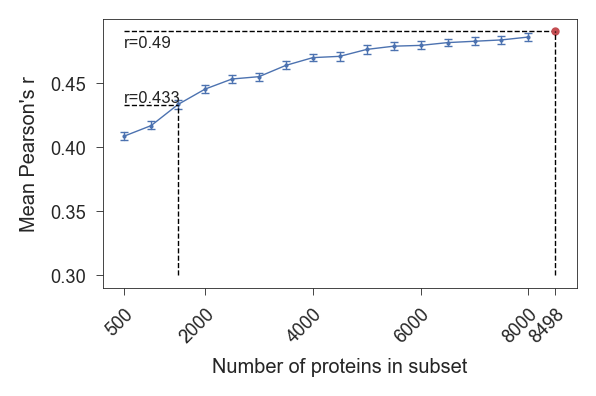

In [26]:
_, ax = plt.subplots(1, 1, figsize=(3, 2))

ax1 = sns.lineplot(x='protein_num',
                   y='corr',
                   data=all_df,
                   err_style='bars',
                   err_kws={
                       "capsize": 1.5,
                       "elinewidth": 0.5,
                       "capthick": 0.5
                   },
                   lw=0.5,
                   marker='o',
                   markersize=1.5,
                   markeredgewidth=0)

ax.set_xticks(sizes + [8498] + [10000, 12000, 14000])
plt.plot([500, 8498], [0.490, 0.490], color='black', lw=0.5, ls='--')
plt.plot([500, 1500], [0.433, 0.433], color='black', lw=0.5, ls='--')
plt.plot(8498, 0.490, 'ro', markersize=2)

plt.plot([1500, 1500], [0.3, 0.433], color='black', lw=0.5, ls='--')
plt.plot([8498, 8498], [0.3, 0.490], color='black', lw=0.5, ls='--')
plt.text(500, 0.435, "r=0.433", size=6)
plt.text(500, 0.487, "r=0.49", size=6, va='top')
plt.xlabel("Number of proteins in subset")
plt.ylabel("Mean Pearson's r")
plt.setp(ax1.get_xticklabels(),
         rotation=45,
         ha="right",
         rotation_mode="anchor")
plt.tight_layout()
# plt.savefig("../../plots/final_plots/Fig6E.pdf", dpi=500)

In [17]:
plot_df = pd.concat([rf_data, dl_data])

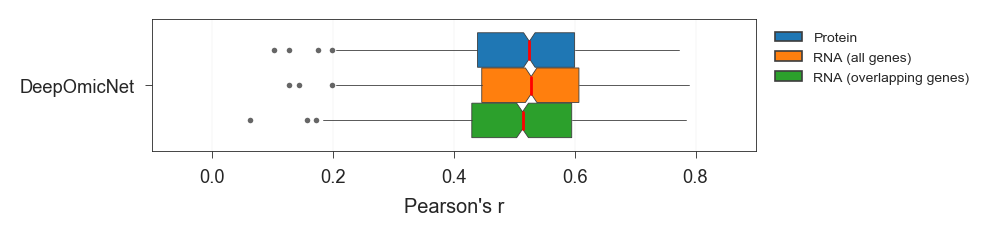

In [24]:
_, ax = plt.subplots(1, 1, figsize=(5, 1.2), dpi=200)

sns.boxplot(
    x="corr",
    y="Model",
    hue="category",
    data=plot_df[plot_df['Model'] == 'DeepOmicNet'],
    #     order=order,
    notch=True,
    boxprops=dict(linewidth=0.3),
    whiskerprops=dict(linewidth=0.3),
    medianprops=CrispyPlot.MEDIANPROPS,
    flierprops=CrispyPlot.FLIERPROPS,
    palette="tab10",
    showcaps=False,
    saturation=1,
    orient="h",
    ax=ax,
)

ax.set_xlabel("Pearson's r")
ax.set_ylabel("")
ax.grid(axis="x", lw=0.1, color="#e1e1e1", zorder=0)

# y1, y2 = 0.73, 1.27  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
# x, w, col = plot_df['corr'].max() + 0.02, 0.02, 'k'
# ax.plot([x, x+w, x+w, x], [y1, y1, y2, y2], lw=0.5, c=col)
# ax.text((x + w) + .02,
#            (y1+y2)/2,
#            r"$\bf{*}\bf{*}\bf{*}$",
#            ha='center',
#            va='center',
#            size=4)
ax.set_xlim(-0.1, 0.9)
ax.legend(prop={"size": 5},
          frameon=False,
          title="",
          loc=2,
          bbox_to_anchor=(1.01, 1))
plt.tight_layout()
plt.savefig("../../plots/final_supp_plots/SuppFig5C.pdf", dpi=500)

In [26]:
plot_df.groupby(['category','Model']).mean()

corr
category                Model                 
Protein                 DeepOmicNet   0.515288
                        RandomForest  0.497237
RNA (all genes)         DeepOmicNet   0.519278
                        RandomForest  0.505875
RNA (overlapping genes) DeepOmicNet   0.508057
                        RandomForest  0.493946

In [19]:
ttest_rel(
    dl_data.query('category == "Protein"')['corr'],
    dl_data.query('category == "RNA (overlapping genes)"')['corr'])

Ttest_relResult(statistic=4.064574612775376, pvalue=5.35038242884427e-05)

In [89]:
ttest_rel(
    dl_data.query('category == "RNA (all genes)"')['corr'],
    dl_data.query('category == "RNA (overlapping genes)"')['corr'])

Ttest_relResult(statistic=9.66054754437305, pvalue=7.957720218832363e-21)

In [90]:
ttest_rel(
    dl_data.query('category == "Protein"')['corr'],
    dl_data.query('category == "RNA (all genes)"')['corr'])

Ttest_relResult(statistic=-2.632662929679954, pvalue=0.008656307434311547)

# housekeeping vs common vs rare

In [26]:
protein_prot = pd.read_csv(
    "../../data/protein/e0022_diann_051021_frozen_matrix_averaged_processed.txt",
    sep='\t',
    index_col=0)

protein_prot_cellline_count = pd.DataFrame(
    protein_prot.shape[0] - protein_prot.isnull().sum(axis=0).sort_values(),
    columns=['Number of cell lines']).reset_index()

protein_prot_cellline_count['percentage'] = protein_prot_cellline_count[
    'Number of cell lines'] / protein_prot.shape[0]

In [27]:
proteins = protein_prot.columns
housekeeping = protein_prot_cellline_count.query('percentage > 0.9')['index'].values
tissue_common = protein_prot_cellline_count.query('0.2 <= percentage <= 0.9')['index'].values
tissue_rare = protein_prot_cellline_count.query('percentage < 0.2')['index'].values

In [28]:
all_df = []
sizes = range(250, len(proteins), 250)
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample/DL/downsample{size}/").rglob("scores_202110*"):
        tmp_score = pd.read_csv(fp)
#         if re.match(".*run_[3-9].*", str(fp)):
#             continue
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                                & (tmp_score['epoch'] == protein_epoch)][[
                                    'drug_id', 'run', 'corr'
                                ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
#         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df.append(one_size_df)
all_df = pd.concat(all_df)

In [29]:
all_df_housekeeping = []
sizes = range(250, len(housekeeping), 250)
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample_housekeeping/DL/downsample{size}/").rglob("scores_202110*"):
        tmp_score = pd.read_csv(fp)
#         if re.match(".*run_[3-9].*", str(fp)):
#             continue
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                                & (tmp_score['epoch'] == protein_epoch)][[
                                    'drug_id', 'run', 'corr'
                                ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
#         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df_housekeeping.append(one_size_df)
all_df_housekeeping = pd.concat(all_df_housekeeping)

In [30]:
all_df_tissue_common = []
sizes = range(250, len(tissue_common), 250)
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample_tissue_common/DL/downsample{size}/").rglob("scores_202110*"):
        tmp_score = pd.read_csv(fp)
#         if re.match(".*run_[3-9].*", str(fp)):
#             continue
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                                & (tmp_score['epoch'] == protein_epoch)][[
                                    'drug_id', 'run', 'corr'
                                ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
#         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df_tissue_common.append(one_size_df)
all_df_tissue_common = pd.concat(all_df_tissue_common)

In [31]:
all_df_tissue_rare = []
sizes = range(250, len(tissue_rare), 250)
for size in sizes:
    one_size_df = []
    for fp in Path(f"../../work_dirs/downsample_tissue_rare/DL/downsample{size}/").rglob("scores_202110*"):
        tmp_score = pd.read_csv(fp)
#         if re.match(".*run_[3-9].*", str(fp)):
#             continue
        max_epoch = tmp_score[tmp_score['run'] == 'test'].groupby(['epoch']).mean()['corr'].reset_index()
        protein_epoch = max_epoch[max_epoch['corr'] == max_epoch['corr'].max()]['epoch'].values[0]
        tmp_test = tmp_score[(tmp_score['run'] == 'test')
                                & (tmp_score['epoch'] == protein_epoch)][[
                                    'drug_id', 'run', 'corr'
                                ]].reset_index(drop=True)

        tmp_cv = tmp_score[tmp_score['run'] != 'test'].reset_index(drop=True)
        tmp_cv_long = deep_learning_cv_score(tmp_cv)
        tmp_df = pd.concat([tmp_test, tmp_cv_long])
#         tmp_df = tmp_test.copy()
        tmp_df = tmp_df.groupby('drug_id').mean().reset_index()
        tmp_df['experiment'] = int(fp.parts[-1].split('_')[-1][0])
        one_size_df.append(tmp_df)
    if len(one_size_df) > 0:
        one_size_df = pd.concat(one_size_df)
        one_size_df['protein_num'] = size
        all_df_tissue_rare.append(one_size_df)
all_df_tissue_rare = pd.concat(all_df_tissue_rare)

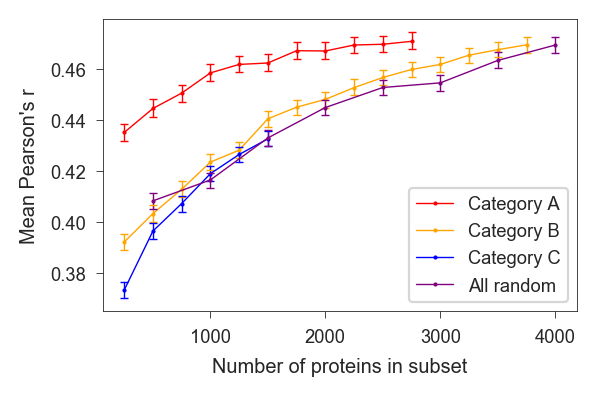

In [33]:
_, ax = plt.subplots(1, 1, figsize=(3, 2))

sns.lineplot(x='protein_num',
             y='corr',
             data=all_df_housekeeping,
             label="Category A",
             color='red',
             err_style='bars',
             err_kws={
                 "capsize": 1.5,
                 "elinewidth": 0.5,
                 "capthick": 0.5
             },
             lw=0.5,
             marker='o',
             markersize=1.5,
             markeredgewidth=0)

sns.lineplot(x='protein_num',
             y='corr',
             data=all_df_tissue_common,
             label="Category B",
             color='orange',
             err_style='bars',
             err_kws={
                 "capsize": 1.5,
                 "elinewidth": 0.5,
                 "capthick": 0.5
             },
             lw=0.5,
             marker='o',
             markersize=1.5,
             markeredgewidth=0)
sns.lineplot(x='protein_num',
             y='corr',
             data=all_df_tissue_rare,
             label="Category C",
             color='blue',
             err_style='bars',
             err_kws={
                 "capsize": 1.5,
                 "elinewidth": 0.5,
                 "capthick": 0.5
             },
             lw=0.5,
             marker='o',
             markersize=1.5,
             markeredgewidth=0)
sns.lineplot(x='protein_num',
             y='corr',
             data=all_df[all_df['protein_num'] <= 4000],
             label="All random",
             color='purple',
             err_style='bars',
             err_kws={
                 "capsize": 1.5,
                 "elinewidth": 0.5,
                 "capthick": 0.5
             },
             lw=0.5,
             marker='o',
             markersize=1.5,
             markeredgewidth=0)

# ax.set_xticks(list(range(250, len(housekeeping), 250)))
plt.xlabel("Number of proteins in subset")
plt.ylabel("Mean Pearson's r")
plt.tight_layout()
plt.savefig("../../plots/final_plots/Fig7E.pdf",
            dpi=500)

In [69]:
all_df_housekeeping.query('protein_num == 250')['corr'].mean()

0.43526189316340014

In [119]:
all_df_housekeeping.query('protein_num == 1500')['corr'].mean()

0.4625317301511909

In [120]:
all_df_tissue_common.query('protein_num == 1500')['corr'].mean()

0.44062538370919974

In [121]:
all_df_tissue_rare.query('protein_num == 1500')['corr'].mean()

0.4327696057193378

## connectivity

In [14]:
protein_frozen = pd.read_csv(
    "../../data/protein/e0022_diann_051021_frozen_matrix_averaged_processed.txt",
    sep='\t')

In [8]:
name_map_df = pd.read_csv(f"../../data/misc/uniprot_human_idmap.tab.gz",
                       sep='\t')
name_map_dict = name_map_df.set_index("Entry name").to_dict()['Gene names  (primary )']
protein2rna_map = name_map_dict
rna2protein_map = name_map_df.set_index("Gene names  (primary )").to_dict()['Entry name']

In [9]:
protein_info = pd.read_csv(
    "../../data/misc/9606.protein.info.v11.0.txt", sep='\t')
protein_id_map = protein_info.set_index(
    'protein_external_id').to_dict()['preferred_name']

protein_links = pd.read_csv(
    "../../data/misc//9606.protein.links.v11.0.txt", sep=' ')
protein_links['protein1'] = protein_links['protein1'].map(protein_id_map)
protein_links['protein2'] = protein_links['protein2'].map(protein_id_map)

In [10]:
protein_links_huri = pd.read_csv(
    "../../data/misc/processed_huri_network.csv.gz")

In [19]:
proteins = protein_prot.columns

In [20]:
genes = [protein2rna_map[x] for x in proteins if x in protein2rna_map]
housekeeping_genes = [protein2rna_map[x] for x in housekeeping if x in protein2rna_map]
tissue_common_genes = [protein2rna_map[x] for x in tissue_common if x in protein2rna_map]
tissue_rare_genes = [protein2rna_map[x] for x in tissue_rare if x in protein2rna_map]

In [21]:
protein_links.shape

(11759454, 3)

In [22]:
protein_links = protein_links[
    (protein_links['protein1'].isin(genes)) &
    (protein_links['protein2'].isin(genes))]

In [23]:
protein_links.shape

(3751098, 3)

In [24]:
protein_links_900 = protein_links[protein_links['combined_score']>990]

In [25]:
protein_links_huri = protein_links_huri.drop(['combined_score'], axis=1)
protein_links_huri.columns = ['protein1', 'protein2']

In [26]:
protein_links_huri = protein_links_huri[
    (protein_links_huri['protein1'].isin(genes))
    & (protein_links_huri['protein2'].isin(genes))]

In [27]:
tissue_rare_degree = []
for prot in tqdm(tissue_rare_genes):
    tissue_rare_degree.append({
        'prot':
        prot,
        'degree': (sum(prot == protein_links_900.iloc[:, 0]) +
                   sum(prot == protein_links_900.iloc[:, 0])) / 2
    })
tissue_rare_degree = pd.DataFrame(tissue_rare_degree)

housekeeping_degree = []
for prot in tqdm(housekeeping_genes):
    housekeeping_degree.append({
        'prot':
        prot,
        'degree': (sum(prot == protein_links_900.iloc[:, 0]) +
                   sum(prot == protein_links_900.iloc[:, 0])) / 2
    })
housekeeping_degree = pd.DataFrame(housekeeping_degree)

tissue_common_degree = []
for prot in tqdm(tissue_common_genes):
    tissue_common_degree.append({
        'prot':
        prot,
        'degree': (sum(prot == protein_links_900.iloc[:, 0]) +
                   sum(prot == protein_links_900.iloc[:, 0])) / 2
    })
tissue_common_degree = pd.DataFrame(tissue_common_degree)

  0%|          | 0/1605 [00:00<?, ?it/s]

  0%|          | 0/2930 [00:00<?, ?it/s]

  0%|          | 0/3904 [00:00<?, ?it/s]

In [28]:
tissue_rare_degree['category'] = 'Category C'
tissue_common_degree['category'] = 'Category B'
housekeeping_degree['category'] = 'Category A'

In [29]:
ttest_ind(housekeeping_degree['degree'].values,
          tissue_common_degree['degree'].values)

Ttest_indResult(statistic=22.003050550171526, pvalue=1.0063051347241614e-103)

In [30]:
ttest_ind(tissue_common_degree['degree'].values,
          tissue_rare_degree['degree'].values)

Ttest_indResult(statistic=6.252223834272922, pvalue=4.350934190437329e-10)

In [31]:
print(housekeeping_degree['degree'].mean())
print(tissue_common_degree['degree'].mean())
print(tissue_rare_degree['degree'].mean())

8.167918088737201
1.5302254098360655
0.6317757009345795


In [32]:
all_protein_degree = pd.concat(
    [housekeeping_degree, tissue_common_degree, tissue_rare_degree])

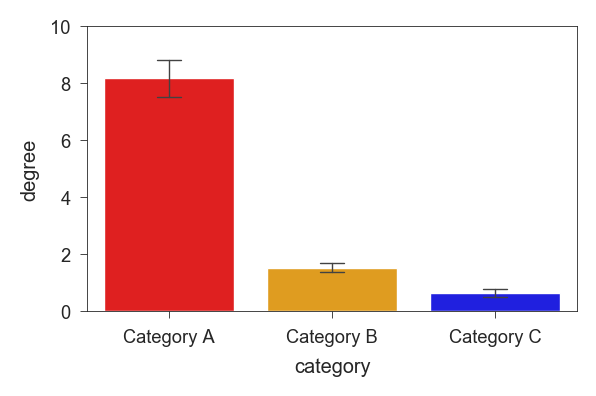

In [63]:
plt.figure(figsize=(3, 2))
sns.barplot(x='category',
            y='degree',
            data=all_protein_degree,
            linewidth=0.5,
            capsize=0.15,
            errwidth=0.5,
            palette=['red', 'orange', 'blue'])
plt.ylim(0,10)
plt.tight_layout()
plt.savefig("../../plots/string_degree.pdf", dpi=500)

In [64]:
G = nx.Graph()
colors = []
for index, row in all_protein_degree.iterrows():
    if row['degree'] < 1:
        continue
        
    if row['prot'] in housekeeping_genes:
        color = 'red'
    elif row['prot'] in tissue_common_genes:
        color = 'orange'
    else:
        color = 'blue'
    G.add_node(row['prot'], color=color)
    colors.append(color)

for index, row in protein_links_900.iterrows():
    if row['protein1'] in G.nodes and row['protein2'] in G.nodes:
        G.add_edge(row['protein1'], row['protein2'])

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



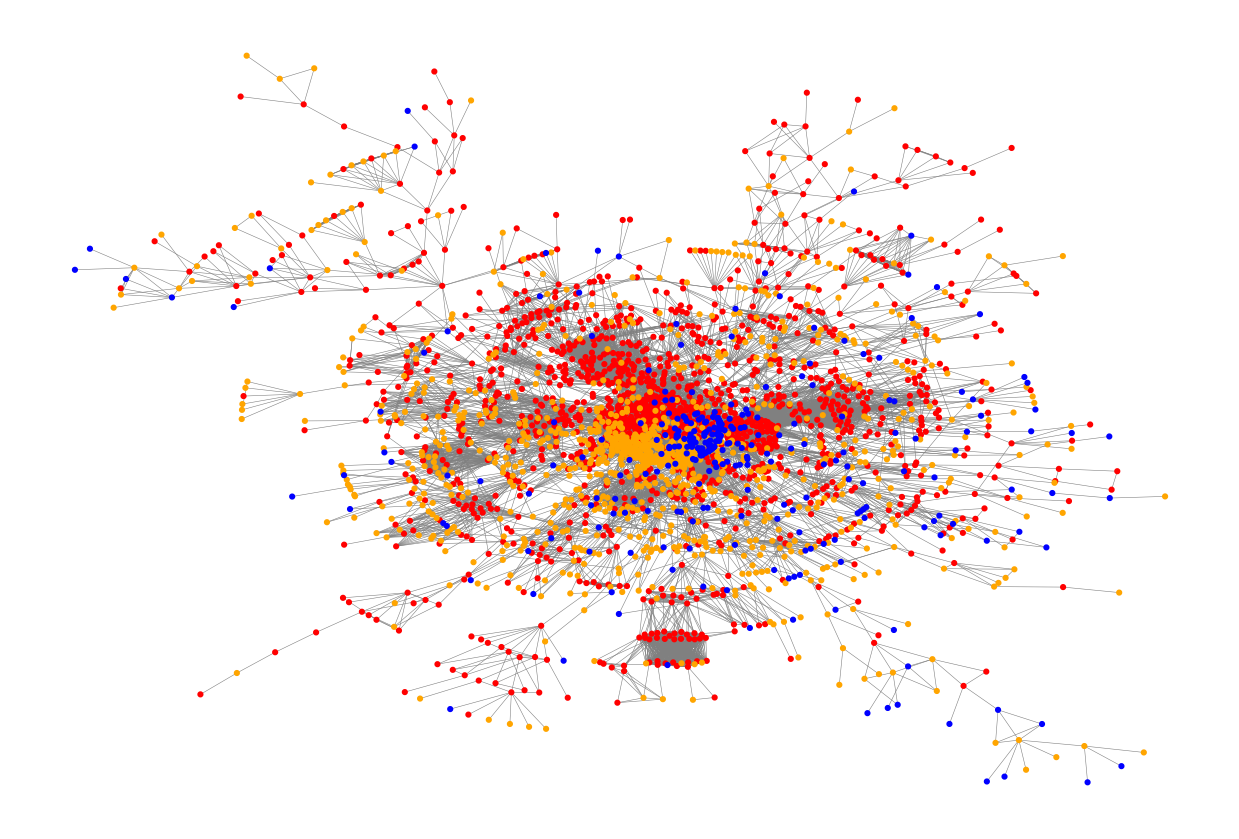

In [65]:
plt.figure(figsize=(6, 4))
nx.draw_kamada_kawai(G,
                     with_labels=False,
                     node_color=colors,
                     node_size=2,
                     width=0.2,
                     edge_color='grey')
plt.savefig("../../plots/final_plots/Fig7E.pdf", dpi=500)

### overlap number of associations

In [121]:
supptable4 = pd.read_csv("../../result_files/lm/drug_supptable_pancancer_270821.csv")

In [122]:
supptable4['beta_abs'] = supptable4['beta'].abs()

In [45]:
all_protein_degree_drugs = pd.merge(
    all_protein_degree,
    supptable4.groupby('x_id').size().reset_index(name='num_associations'),
    how='outer',
    left_on='prot',
    right_on='x_id').fillna(0.2)

In [93]:
all_protein_degree_drugs_inner = pd.merge(
    all_protein_degree,
    supptable4.groupby('x_id').size().reset_index(name='num_associations'),
    how='inner',
    left_on='prot',
    right_on='x_id')

In [123]:
all_protein_degree_beta = pd.merge(
    all_protein_degree,
    supptable4,
    how='inner',
    left_on='prot',
    right_on='x_id')

In [48]:
G = nx.Graph()
colors = []
for index, row in all_protein_degree_drugs.iterrows():
    if row['degree'] < 1:
        continue
        
    if row['prot'] in housekeeping_genes:
        color = 'red'
    elif row['prot'] in tissue_common_genes:
        color = 'orange'
    else:
        color = 'blue'
    G.add_node(row['prot'], color=color)
    colors.append(color)

for index, row in protein_links_900.iterrows():
    if row['protein1'] in G.nodes and row['protein2'] in G.nodes:
        G.add_edge(row['protein1'], row['protein2'])

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



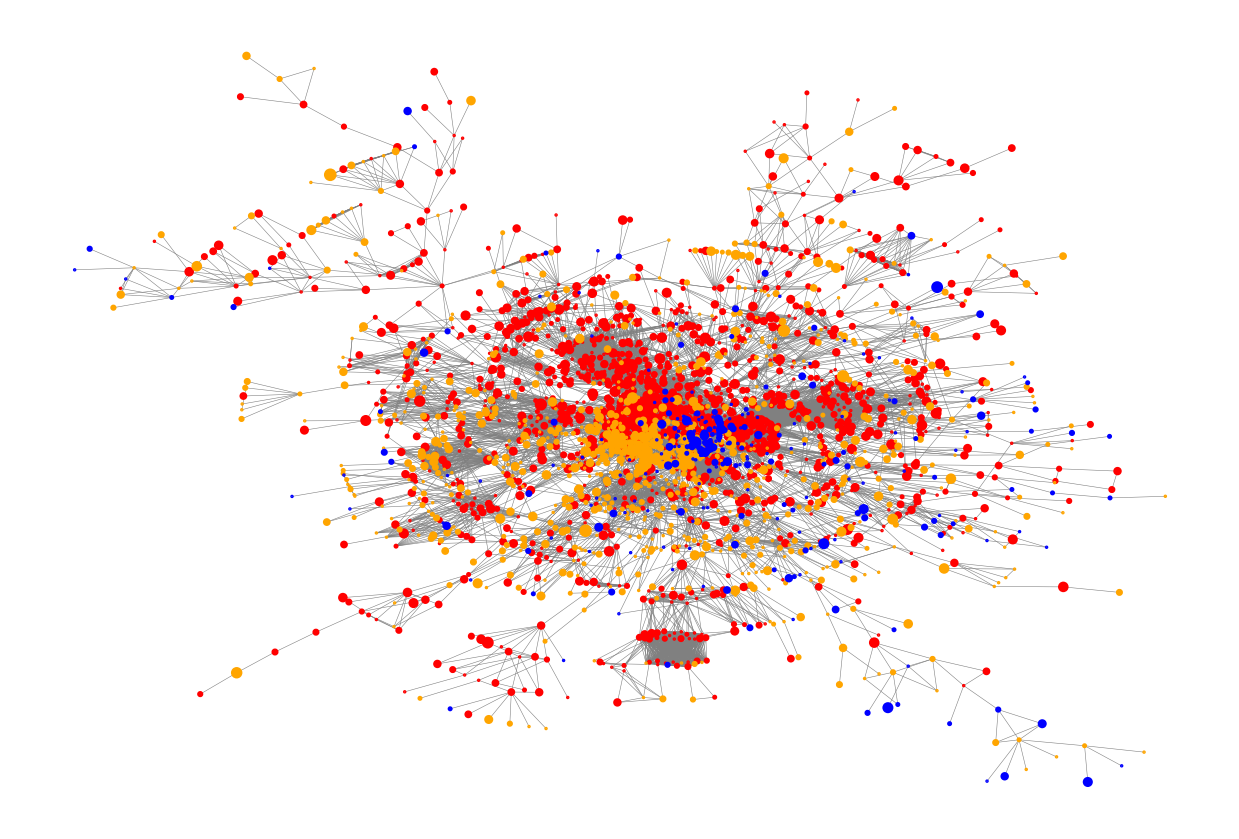

In [49]:
plt.figure(figsize=(6, 4))
nx.draw_kamada_kawai(G,
                     with_labels=False,
                     node_color=colors,
                     node_size=all_protein_degree_drugs['num_associations'].values,
                     width=0.2,
                     edge_color='grey')

### parallel

In [50]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
housekeeping_genes

In [56]:
supptable4['category'] = supptable4['x_id'].map(
    lambda x: 'CatA' if x in housekeeping_genes else 'CatB'
    if x in tissue_common_genes else 'CatC')

In [80]:
supptable4['cat_color'] = supptable4['category'].map(
    lambda x: 'red' if x == 'CatA' else 'orange'
    if x == 'CatB' else 'blue')

In [66]:
supptable4['fdr_plot'] = supptable4['fdr'].map(lambda x:-np.log10(x))

In [72]:
df = px.data.tips()
fig = px.parallel_categories(supptable4.head(20), dimensions=['y_id', 'x_id', 'category'],
                color="fdr_plot", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

In [88]:
df = px.data.tips()
fig = px.parallel_categories(supptable4.head(20), dimensions=['y_id', 'x_id', 'category'], color='cat_color')
fig.show()

In [107]:
df = px.data.tips()
fig = px.parallel_categories(supptable4, dimensions=['target', 'category'], color='cat_color')
fig.show()

In [ ]:
# Create dimensions
class_dim = go.parcats.Dimension(
    values=['y_id', 'category'],
    categoryorder='category ascending', label="Class"
)

gender_dim = go.parcats.Dimension(values=titanic_df.Sex, label="Gender")

survival_dim = go.parcats.Dimension(
    values=titanic_df.Survived, label="Outcome", categoryarray=[0, 1],
    ticktext=['perished', 'survived']
)

# Create parcats trace
color = titanic_df.Survived;
colorscale = [[0, 'lightsteelblue'], [1, 'mediumseagreen']];

fig = go.Figure(data = [go.Parcats(dimensions=[class_dim, gender_dim, survival_dim],
        line={'color': color, 'colorscale': colorscale},
        hoveron='color', hoverinfo='count+probability',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
        arrangement='freeform')])

fig.show()

### scatter

In [97]:
all_protein_degree_drugs_inner

prot  degree    category       x_id  num_associations
0         HSPA4     4.0  Category A      HSPA4                 8
1     HNRNPA2B1    30.0  Category A  HNRNPA2B1                 2
2          RPS7   105.0  Category A       RPS7                 2
3         EEF1D     2.0  Category A      EEF1D                 2
4          RTN4     0.0  Category A       RTN4                 3
...         ...     ...         ...        ...               ...
2843      HTRA1     0.0  Category C      HTRA1                 1
2844       KLK6     0.0  Category C       KLK6                 1
2845     ELAVL3     0.0  Category C     ELAVL3                 1
2846       SGCD     0.0  Category C       SGCD                 3
2847       SPI1     0.0  Category C       SPI1                 1

[2848 rows x 5 columns]

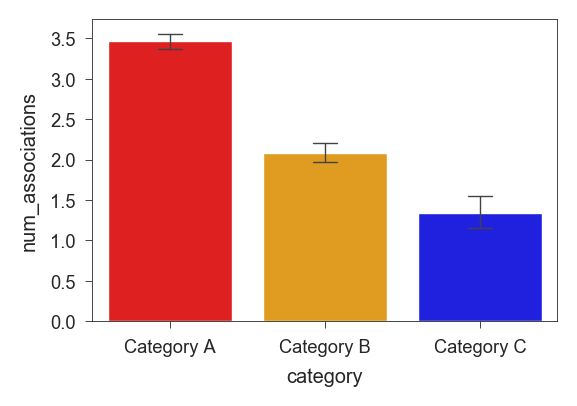

In [100]:
plt.figure(figsize=(3, 2))
sns.barplot(x='category',
            y='num_associations',
            data=all_protein_degree_drugs_inner,
            linewidth=0.5,
            capsize=0.15,
            errwidth=0.5,
            palette=['red', 'orange', 'blue'])

### 1000

In [288]:
proteins_1000 = pd.read_csv(
    "../../data/protein/downsample/downsample_1000.csv").iloc[:,0]
proteins_1000 = [protein2rna_map[x] for x in proteins_1000 if x in protein2rna_map]

proteins_housekeeping_1000 = pd.read_csv(
    "../../data/protein/downsample_housekeeping/downsample_1000.csv").iloc[:,0]
proteins_housekeeping_1000 = [protein2rna_map[x] for x in proteins_housekeeping_1000 if x in protein2rna_map]

proteins_tissue_common_1000 = pd.read_csv(
    "../../data/protein/downsample_tissue_common/downsample_1000.csv").iloc[:,0]
proteins_tissue_common_1000 = [protein2rna_map[x] for x in proteins_tissue_common_1000 if x in protein2rna_map]

proteins_tissue_rare_1000 = pd.read_csv(
    "../../data/protein/downsample_tissue_rare/downsample_1000.csv").iloc[:,0]
proteins_tissue_rare_1000 = [protein2rna_map[x] for x in proteins_tissue_rare_1000 if x in protein2rna_map]

In [323]:
G = nx.Graph()
colors = []
sizes = []
sizes_housekeeping = []
sizes_tissue_common = []
sizes_tissue_rare = []

node_alpha = []
node_alpha_housekeeping = []
node_alpha_tissue_common = []
node_alpha_tissue_rare = []

for index, row in all_protein_degree.iterrows():
    if row['degree'] < 1:
        continue
        
    if row['prot'] in housekeeping_genes:
        color = 'red'
    elif row['prot'] in tissue_common_genes:
        color = 'orange'
    else:
        color = 'blue'
        
    if row['prot'] in proteins_1000:
        sizes.append(6)
        
    else:
        sizes.append(0.5)
        
    if row['prot'] in proteins_housekeeping_1000:
        node_alpha_housekeeping.append(1)
        sizes_housekeeping.append(6)
    else:
        node_alpha_housekeeping.append(0.5)
        sizes_housekeeping.append(0.5)
    
    if row['prot'] in proteins_tissue_common_1000:
        sizes_tissue_common.append(6)
    else:
        sizes_tissue_common.append(0.5)
        
    if row['prot'] in proteins_tissue_rare_1000:
        sizes_tissue_rare.append(6)
    else:
        sizes_tissue_rare.append(0.5)
    
    G.add_node(row['prot'], color=color)
    colors.append(color)

for index, row in protein_links_900.iterrows():
    if row['protein1'] in G.nodes and row['protein2'] in G.nodes:
        G.add_edge(row['protein1'], row['protein2'])

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



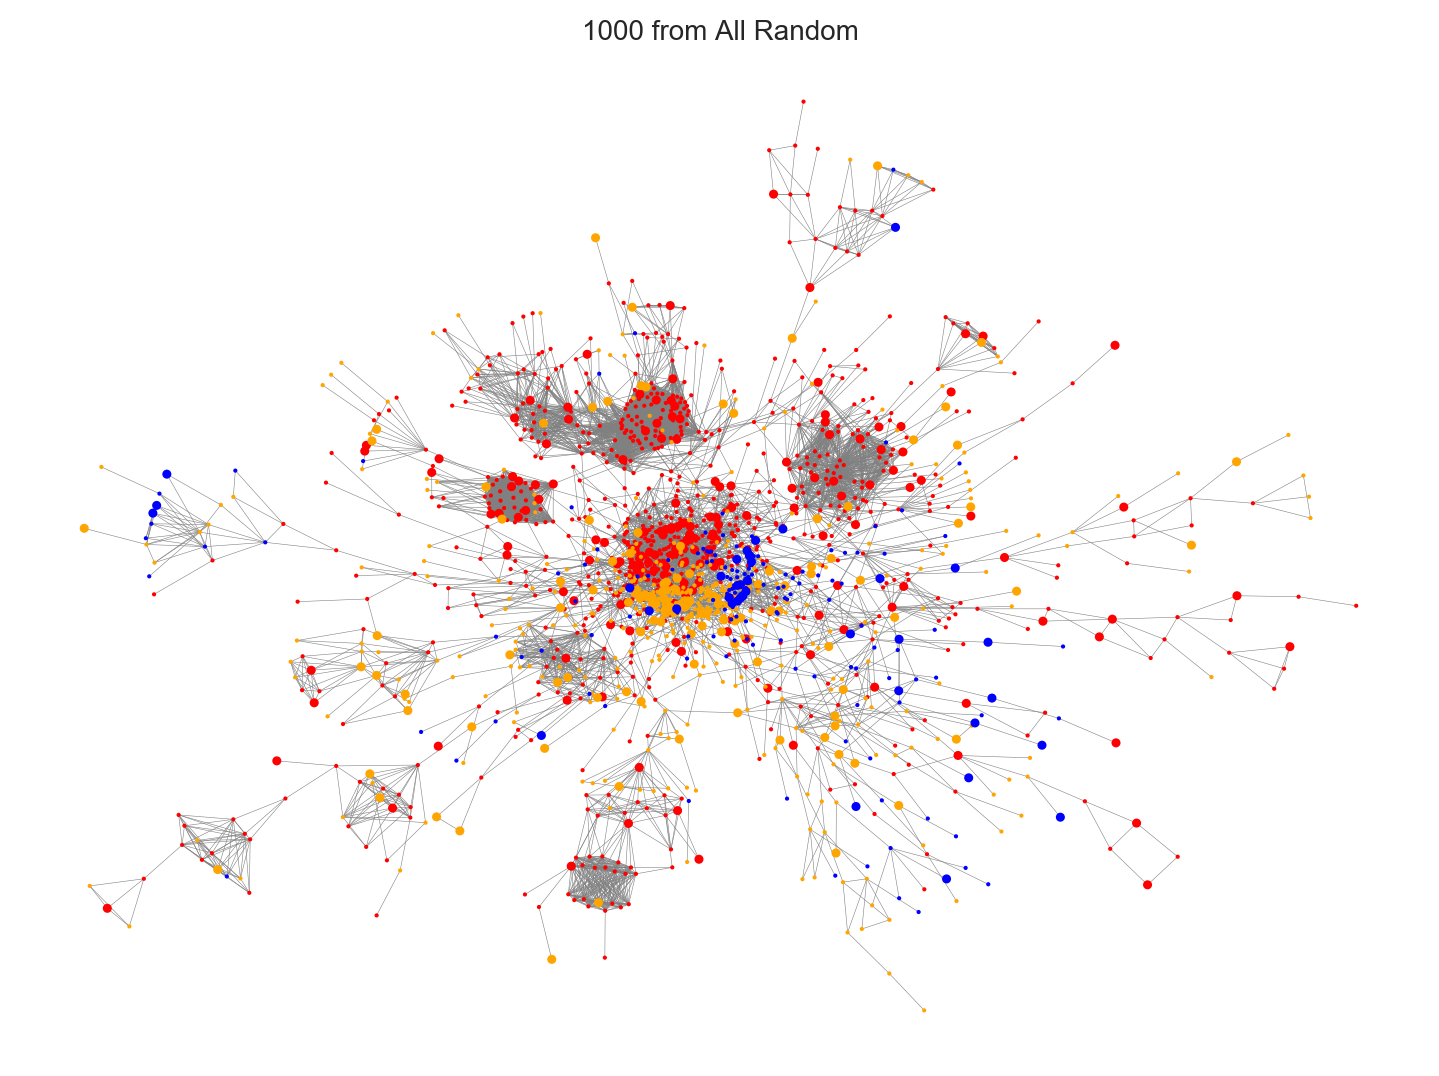

In [328]:
plt.figure(figsize=(7, 5))
nx.draw_kamada_kawai(G,
                     with_labels=False,
                     node_color=colors,
                     node_size=sizes,
                     width=0.2,
                     edge_color='grey')
plt.title('1000 from All Random', fontsize=10)
plt.savefig("../../plots/All_random_1000.pdf", dpi=500)

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



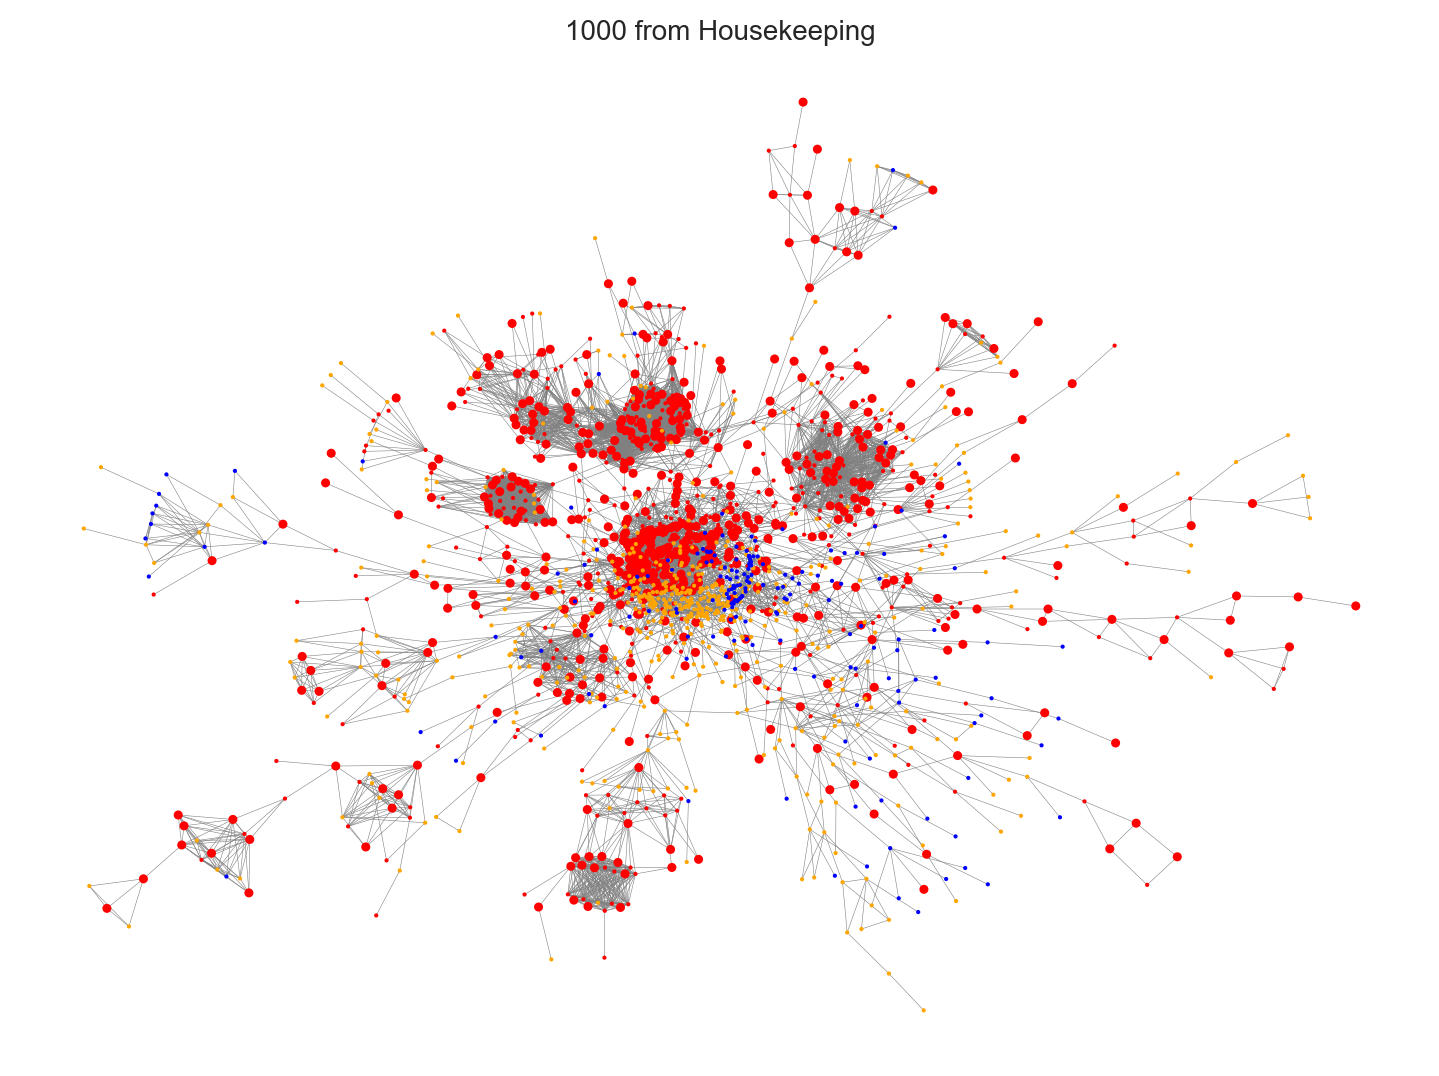

In [329]:
plt.figure(figsize=(7, 5))
nx.draw_kamada_kawai(G,
                     with_labels=False,
                     node_color=colors,
                     node_size=sizes_housekeeping,
                     width=0.2,
                     edge_color='grey',
                     node_alpha=node_alpha_housekeeping)
plt.title('1000 from Housekeeping', fontsize=10)
plt.savefig("../../plots/housekeeping_1000.pdf", dpi=500)

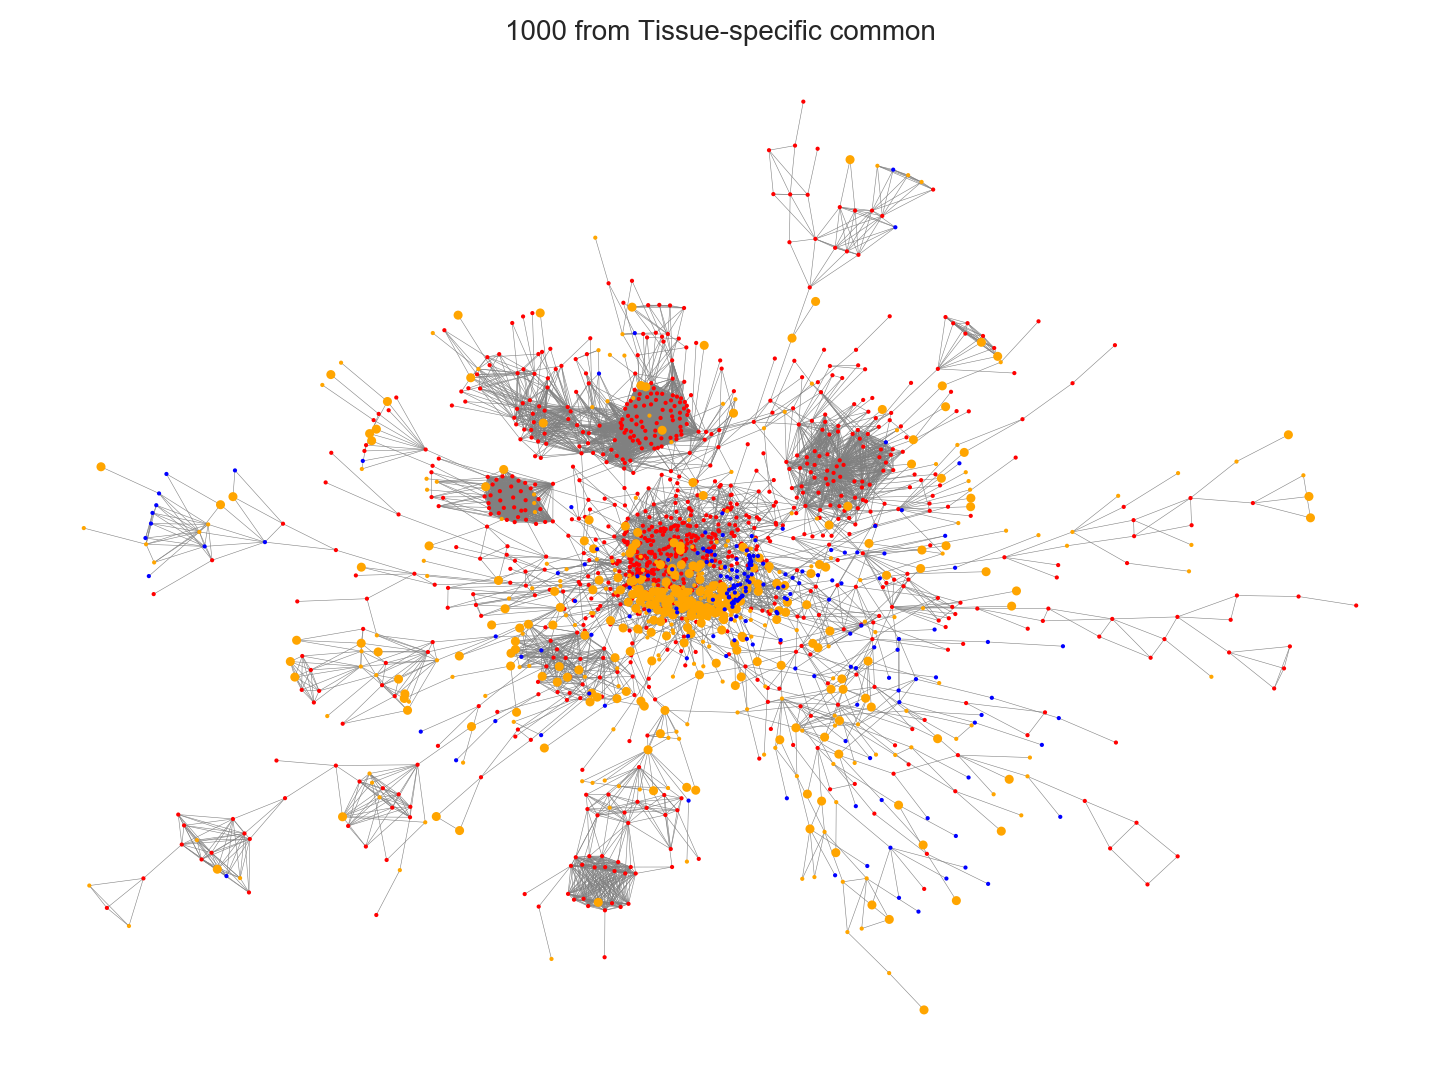

In [330]:
plt.figure(figsize=(7, 5))
nx.draw_kamada_kawai(G,
                     with_labels=False,
                     node_color=colors,
                     node_size=sizes_tissue_common,
                     width=0.2,
                     edge_color='grey')
plt.title('1000 from Tissue-specific common', fontsize=10)
plt.savefig("../../plots/tissue_common_1000.pdf", dpi=500)

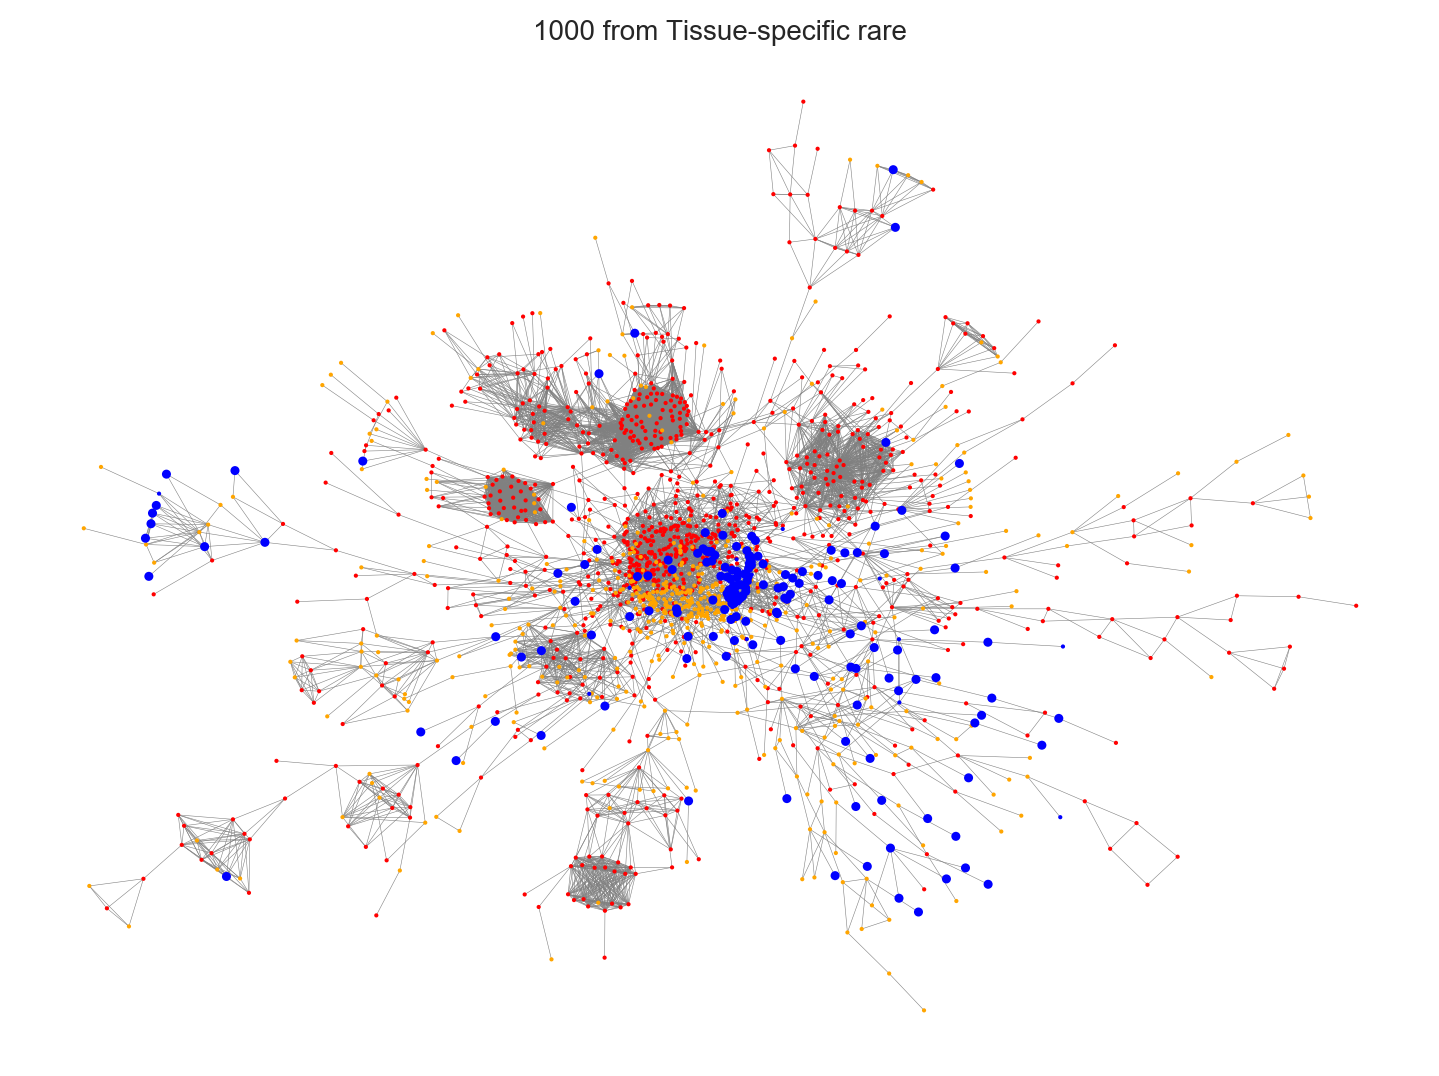

In [331]:
plt.figure(figsize=(7, 5))
nx.draw_kamada_kawai(G,
                     with_labels=False,
                     node_color=colors,
                     node_size=sizes_tissue_rare,
                     width=0.2,
                     edge_color='grey')
plt.title('1000 from Tissue-specific rare', fontsize=10)
plt.savefig("../../plots/tissue_rare_1000.pdf", dpi=500)